### Notebook to analyse *.nc files (with single variables) 

In [16]:
#TODO: extend to multiple variables 

# Imports
import cartopy
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from iris.util import rolling_window
from ruamel import yaml
from tqdm import tqdm
from ruamel.yaml import ruamel
import warnings

import os

Utilizing 
https://scitools.org.uk/iris/docs/latest/

#### Data import

In [17]:
# test for multi model execution
# just data from one model is used, TODO: generalization

data_dictionary = {}
model = 'ISIMIP3b-MPI-ESM-1-2-HR'
data_dictionary [model,'historical']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output/data_mpi-esm1-2-hr.yml'
data_dictionary [model,'ssp126']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml'
data_dictionary [model,'ssp585']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp585/output/data_mpi-esm1-2-hr.yml'

# generate dictionary of  data [model,scenario]



# get all keys from dictionary
data_keys = data_dictionary.keys()
filepaths = {}
for i_key in data_keys:
    with open(data_dictionary[i_key], 'r') as stream:
            try:
                filepaths[i_key] = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
print(filepaths)


{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): ['/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_20012010.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_19811990.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_19011910.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_18811890.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_19511960.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_18711880.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_19711980.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output_mpi-esm1-2-hr_historical_18911900.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/ou

### Data preparation

In [18]:

# functions to filter for specific variables, add seasons etc

def filter_cube (cube,variablename):
    return cube.extract(variablename)
   
# constrain cubelists

def latitude_constraint(latitude,cube):
    # restrict on latitudes above northern tropic
    latitudeConstraint = iris.Constraint(latitude=lambda v: latitude <= v)
    return cube.extract(latitudeConstraint)

def add_seasons (cubelist):
    for i_cube in cubelist:
        iris.coord_categorisation.add_season(i_cube, 'time', name='season')
        iris.coord_categorisation.add_season_year(i_cube, 'time', name='season_year')
    return cubelist

    
    

In [19]:
# load data

variablename = "approx_fresh_daily_snow_height"
cubelist = {}
for i_key in data_keys:
    cubelist[i_key] = add_seasons(latitude_constraint(23,iris.load(filepaths[i_key],variablename)))

In [20]:
print(cubelist)

# ignore warnings
warnings.simplefilter("ignore")

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): [<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 365; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653;

In [21]:
# concatenate all country cubes by time
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes 
def unify_concatenate(cubelist):
    unify_time_units(cubelist)
    equalise_attributes(cubelist)
    
    return cubelist.concatenate_cube()

In [22]:
# function to generate for polynomial fit
def quadratic_fit (cube):
 # Calculate a polynomial fit to the data at this time series.
    x_points = cube.coord('time').points
    y_points = cube.data
    degree = 2

    p = np.polyfit(x_points, y_points, degree)
    y_fitted = np.polyval(p, x_points)

    # Add the polynomial fit values to the time series to take
    # full advantage of Iris plotting functionality.
    long_name = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    fit = iris.coords.AuxCoord(y_fitted, long_name=long_name,
                               units=cube.units)
    cube.add_aux_coord(fit, 0)

    iplt.plot(cube.coord('time'), cube, label='data')
    iplt.plot(cube.coord('time'),
              cube.coord(long_name),
              'g-', label='polynomial fit')
    title = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    plt.title(title)
    plt.legend(loc='best')



In [23]:
# generate extra cube of decade 2011 to 2020 (with ssp585 data)
cubes_to_concatenate = iris.cube.CubeList()
cubes_to_concatenate.append(cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'historical'][17])
cubes_to_concatenate.append(cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'][0])

cube_2011_2020 = unify_concatenate(cubes_to_concatenate)
print(cube_2011_2020)
cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'historical'][17]=cube_2011_2020
print(cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'historical'])

approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
     Dimension coordinates:
          time                            x               -               -
          latitude                        -               x               -
          longitude                       -               -               x
     Auxiliary coordinates:
          season                          x               -               -
          season_year                     x               -               -
     Attributes:
          contact: lennart.quante@pik-potsdam.de
          created_with: https://github.com/lquante/snow-processing by S. Willner & L. Quante
0: approx_fresh_daily_snow_height / (1) (time: 365; latitude: 134; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
3: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longi

In [24]:
# filter for specific season
def filter_season(cube,season):
    season_constr = iris.Constraint(season=season)
    return cube.extract(season_constr)
    

In [25]:
# add area bounds to enable area weighted mean:
def add_lon_lat_bounds (cube):
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()


In [26]:
def prepare_season_stats(cubedict,season):
    keys = cubedict.keys()
    season_dict = {}
    for i_key in keys:
        season_cube = filter_season(cubedict[i_key],season)
        season_dict [i_key]    = season_cube                                     
    return season_dict


In [27]:
# define method to plot cube statistics


def mean_cube(cube):
    print("Plot mean")    

    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MEAN)
    cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
    quadratic_fit(collapsed)
    plt.show()
def percentiles_cube(cube):
    print("Plot percentiles")
    percentiles = [99.99,99.9,99,95]
    for percentile in tqdm(percentiles):
        print("percentile: "+str(percentile))
        aggregated = cube.aggregated_by(['season_year'],iris.analysis.PERCENTILE,percent=[percentile])
        cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
        collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
        quadratic_fit(collapsed)
        plt.show()
def max_cube(cube):
    print("Plot max")    
    # loop to plot country limited data graphs
    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MAX)
    cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
    quadratic_fit(collapsed)
    plt.show()

def cube_stats (cube):
    
    mean_cube(cube)
    
    percentiles_cube(cube)

    max_cube(cube)
    
    
# wrapper method to handle dictionary of cubes from different models, scenarios, seasons etc.

def dictonary_cube_stats (cubedict):
    dict_keys = cubedict.keys()
    for i_key in dict_keys:
        print(str(i_key))
        mean_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        max_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        percentiles_cube(cubedict[i_key])
    

In [28]:
# define method to plot global cube stats)
        
    
# wrapper method to handle dictionary of cubes from different models, scenarios, seasons etc.

def dictonary_global_stats (cubedict):
    dict_keys = cubedict.keys()
    for i_key in dict_keys:    
        print(str(i_key))
        mean_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        max_cube(cubedict[i_key])

In [29]:
#load population data used for weighting to enable backscaling by total population of analysed area:

population_2020= iris.load_cube('/home/quante/projects/CMIP6_extreme_snow_events/auxilary_data/gpw_v4_population_count_rev11_30_min_renamed.nc').extract(iris.Constraint(raster=5))
population_2020 = population_2020.regrid(cubelist[('ISIMIP3b-MPI-ESM-1-2-HR', 'historical')][1], iris.analysis.Linear(
                extrapolation_mode='extrapolate'))

# scale to mln people to reduce overflows
population_2020 = population_2020 / 1000000 

#methods to weight area data by population / total population

def population_scaling (data_cube,population_cube):
    population_scaled_data = data_cube.data*population_cube.data
    population_scaled_cube = data_cube.copy(data=population_scaled_data)
    var_name = data_cube.var_name
    var_name_extended = (var_name + '_multiplied_population')
    return population_scaled_cube

def population_weighting (data_cube,area_bounding_box,population_cube):

    restricted_population_data=cube_from_bounding_box(population_cube,area_bounding_box).data
    restricted_data= cube_from_bounding_box(data_cube,area_bounding_box)
    
    population_weighted_data = restricted_data.data*restricted_population_data
    population_scaled_data = population_weighted_data / np.sum(restricted_population_data)
    

    
    # genererate new cube
    population_scaled_cube = restricted_data.copy(data=population_scaled_data) 
  
    var_name = data_cube.var_name
    var_name_extended = (var_name + '_population_weighted')
    population_scaled_cube.var_name = var_name_extended

    return population_scaled_cube


In [173]:
def generate_threshold_development (cube,startyear,finalyear,intensity=False):

    cube_years = extract_dates(cube,startyear,finalyear)
    
    
   

    # general threshold specs
    
    start_threshold = 500
    threshold_step = 5
    final_threshold = 1500
    thresholds = np.arange(start_threshold,final_threshold+threshold_step,threshold_step)
    # calculate exceedance cubes for plotting of maps etc
    
    map_threshold_step = 250
    map_thresholds = np.arange(start_threshold,final_threshold+map_threshold_step,map_threshold_step)
    threshold_cubes = {}
    for i_threshold in map_thresholds:
        threshold_cubes[str(i_threshold),'map']= cube_years.collapsed('time',iris.analysis.COUNT,function = lambda x: x>i_threshold)
       
    
    
    dataarray = flattened_data_array(cube_years)
    thresholds = np.arange(start_threshold,final_threshold+threshold_step,threshold_step)
    exceedances = np.empty(thresholds.size)
    if intensity:
        intensities = np.empty(thresholds.size)
        
    # count number of events above threshold for all thresholds
    index_array = 0
    for i_threshold in thresholds:
        exceedances[index_array]=count_threshold_exceedances(dataarray,i_threshold)
        if intensity:
            intensities[index_array] = np.sum(dataarray[dataarray>i_threshold])
        index_array +=1
    data = {}
    data ['exceedance_array'] = np.vstack((thresholds,exceedances))
    if intensity:
        data ['intensity_array'] = np.vstack((thresholds,intensities))
    data ['map_cubes']=threshold_cubes
    return data
    
def count_threshold_exceedances (dataarray,threshold):
    
    return (dataarray[dataarray>threshold].size) 

In [31]:
# methods to generate distribuition of all events in a certain cube, limited by time constraints


from iris.time import PartialDateTime
import datetime


# test:  generate histogram from data array


def generate_density_histogramm (cube,startyear,finalyear,percentile_cap,label,color):
    cube_years = extract_dates(cube,startyear,finalyear)
    dataarray = flattened_data_array(cube_years)
    maximum=np.percentile(dataarray,100)
    print(maximum)
    percentile=np.percentile(dataarray,percentile_cap)
    print(percentile)
    stepsize = (maximum-percentile)/100
   
    bins=np.arange(percentile,maximum+stepsize,stepsize)
    plt.title(str(startyear)+" to "+str(finalyear))
   
    return plt.hist(dataarray,density=True,bins=bins,cumulative=False,label=label,color=color)



def compare_decades (historical_cube,ssp126_cube,ssp585_cube,percentile,historical_start,historical_later_start,ssp_start,ssp_later_start,cumulative=False,countryname="",zoom=False,population=False):
    
    compare_timespans (historical_cube,ssp126_cube,ssp585_cube,percentile,10,historical_start,historical_later_start,ssp_start,ssp_later_start,cumulative=cumulative,countryname=countryname,zoom=zoom,population=population)


    
def compare_timespans (historical_cube,ssp126_cube,ssp585_cube,percentile,number_of_years_to_compare,historical_start,historical_later_start,ssp_start,ssp_later_start,cumulative=False,countryname="",zoom=False,population=False):
    historical_start_year = historical_start
    historical_final_year = historical_start+number_of_years_to_compare-1
    historical_later_start_year = historical_later_start
    historical_later_final_year = historical_later_start+number_of_years_to_compare-1
    ssp_start_year = ssp_start
    ssp_final_year =ssp_start+number_of_years_to_compare-1
    ssp_later_start_year = ssp_later_start
    ssp_later_final_year = ssp_later_start+number_of_years_to_compare-1
    historical_color  = 'navy'
    ssp126_color = 'orangered'
    ssp585_color = 'darkred'
    
    historical_early_color = 'navy'
    ssp126_early_color = 'orangered'
    ssp585_early_color = 'darkred'
    
    
    print(historical_cube)

    fig = plt.figure(figsize=(15, 10))
  
    suptitle = str(str(countryname)+' - comparison of density above '+str(percentile) +'th percentile')
   
    
    ax1 = plt.subplot(231)
    if (zoom):
        custom_ylim=(0,0.0005)
        plt.setp(ax1, ylim=custom_ylim)
        suptitle += str(' - zoomed in to values below 0.0005')
    generate_density_histogramm(historical_cube,historical_start_year,historical_final_year,percentile,'historical',historical_early_color)
    plt.suptitle(suptitle)

    
    ax2 = plt.subplot(232,sharex=ax1, sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp126_cube,ssp_start_year,ssp_final_year,percentile,'ssp126',ssp126_early_color)
    
    ax3 = plt.subplot(233,sharex=ax1, sharey=ax1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp585_cube,ssp_start_year,ssp_final_year,percentile,'ssp585',ssp585_early_color)
    
    fig.legend(loc='lower right')
    
    ax4 = plt.subplot(234,sharex=ax1, sharey=ax1)
    plt.setp(ax4.get_yticklabels(), visible=True)
    generate_density_histogramm(historical_cube,historical_later_start_year,historical_later_final_year,percentile,'historical_later',historical_color)

    ax5 = plt.subplot(235,sharex=ax1, sharey=ax1)
    plt.setp(ax5.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp126_cube,ssp_later_start_year,ssp_later_final_year,percentile,'ssp126_later',ssp126_color)
    
    ax6 = plt.subplot(236,sharex=ax1, sharey=ax1)
    plt.setp(ax6.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp585_cube,ssp_later_start_year,ssp_later_final_year,percentile,'ssp585_later',ssp585_color)
    
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    xlabel = 'daily snowfall (mm)'
    if (population):
        xlabel +=" * (persons per grid cell / total population of country)" 
    plt.xlabel(xlabel)

   
    plt.show()
    
    
# function to use any country / area limited data

def country_decade_comparison(basic_cubelist,country_box,season,countryname,population):
    #filter data for country box:
    country_data = country_filter(basic_cubelist,country_box)
    # filter for season to reduce computational load, winter snowfalls anyway top percentile most likely
    country_data = prepare_season_stats (country_data,season)
    if (population):
        historical_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical'],country_box,population_2020)
        ssp126_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'],country_box,population_2020)
        ssp585_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'],country_box,population_2020)
        plt.close()
        compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,population=population)
        
        compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,zoom=True,population=population)
    else:
        historical_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
        ssp126_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
        ssp585_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
        plt.close()
        compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,population=population)
        compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,zoom=True,population=population)
    
    

In [175]:
def calculate_decades_threshold_frequency (historical_cube,ssp126_cube,ssp585_cube,number_of_decades,historical_start,ssp_start,intensity=False):
    
    return calculate_timespans_threshold_frequency (historical_cube,ssp126_cube,ssp585_cube,10,number_of_decades,historical_start,ssp_start,intensity=intensity)


def calculate_timespans_threshold_frequency (historical_cube,ssp126_cube,ssp585_cube,number_of_years_to_compare,number_of_timeperiods,historical_start,ssp_start,intensity=False):
    historical_start_list = []
   
    historical_start_list.append(historical_start)

    
    ssp_start_list = []
    
    ssp_start_list.append(ssp_start)
    
    

    for index in range(1, number_of_timeperiods):
        historical_start_list.append(historical_start_list [index-1]+number_of_years_to_compare)
        
        ssp_start_list.append(ssp_start_list [index-1]+number_of_years_to_compare)
      
    ssp_cube = ssp585_cube
    

    data = {}
    
    for i_historical_start in historical_start_list:
        i_historical_end = i_historical_start+number_of_years_to_compare-1
        data ['historical',i_historical_start,i_historical_end] = generate_threshold_development(historical_cube,i_historical_start,i_historical_end,intensity=intensity)

    for i_ssp_start in ssp_start_list:
        i_ssp_end = i_ssp_start+number_of_years_to_compare-1
        data ['ssp',i_ssp_start,i_ssp_end] = generate_threshold_development(ssp585_cube,i_ssp_start,i_ssp_end,intensity=intensity)

    
    return (data)


In [129]:


def plot_exceedance_array(data,format,color,label=''):
    thresholds = data [0]
    exceedances = data [1]
    
    plot = plt.plot(thresholds,exceedances,format,color=color,label=label)
    # zero line
    plt.axhline(linewidth=1)




def calculate_mean_array(data):
    mean = data ['intensity_array'][1]/data ['exceedance_array'][1]
    thresholds = data ['exceedance_array'][0]
    return np.vstack((thresholds,mean))

def plot_timeframe_scenario (data,scenario,start,end,array_key,color,label='',mean=False):  
    if (mean):
        array = calculate_mean_array(data [scenario,start,end])
    else:
        array=data [scenario,start,end][array_key]
    plot_exceedance_array (array,'.',color,label=label)
    plt.title(str(start)+" to "+str(end))
    return array 

def compare_decades_threshold_frequency (data,historical_start,ssp_start,cumulative=False,countryname="",intensity=False,mean=False):
    
    compare_timespans_threshold_frequency (data,10,historical_start,ssp_start,cumulative=cumulative,countryname=countryname,intensity=intensity,mean=mean)


def compare_timespans_threshold_frequency (data,number_of_years_to_compare,historical_start,ssp_start,cumulative=False,countryname="",intensity=False,mean=False):
    historical_1_start = historical_start
    historical_1_end = historical_start+number_of_years_to_compare-1
    historical_2_start = historical_1_end+1
    historical_2_end = historical_1_end+number_of_years_to_compare
    historical_3_start = historical_2_end+1
    historical_3_end = historical_2_end+number_of_years_to_compare
    
    ssp_1_start =ssp_start
    ssp_1_end = ssp_start+number_of_years_to_compare-1
    ssp_2_start = ssp_1_end+1
    ssp_2_end = ssp_1_end+number_of_years_to_compare
    ssp_3_start = ssp_2_end+1
    ssp_3_end = ssp_2_end+number_of_years_to_compare
    
    historical_color  = 'navy'
    ssp126_color = 'orangered'
    ssp585_color = 'darkred'
    ssp_color = ssp585_color

    comparisoncolor = 'black'
    
    if intensity:
        array_key = 'intensity_array'
        title_keyword = 'intensity'
    else:
        array_key = 'exceedance_array'
        title_keyword = 'number'

    if mean:
        title_keyword = 'mean'
    
    fig = plt.figure(figsize=(15, 15))
  
    suptitle = str(str(countryname)+' - comparison of '+title_keyword+' of daily snowfall > threshold events')
   
    
    ax1 = plt.subplot(331)
    historical1 = plot_timeframe_scenario (data,'historical',historical_1_start,historical_1_end,array_key,historical_color,label='historical',mean=mean)

    plt.suptitle(suptitle)
    ax2 = plt.subplot(332,sharex=ax1, sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    historical2 = plot_timeframe_scenario (data,'historical',historical_2_start,historical_2_end,array_key,historical_color,mean=mean)
    
    ax3 = plt.subplot(333,sharex=ax1, sharey=ax1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    historical3 = plot_timeframe_scenario (data,'historical',historical_3_start,historical_3_end,array_key,historical_color,mean=mean)
    
    
    
    ax4 = plt.subplot(334,sharex=ax1, sharey=ax1)
    plt.setp(ax4.get_yticklabels(), visible=True)
    ssp1= plot_timeframe_scenario (data,'ssp',ssp_1_start,ssp_1_end,array_key,ssp_color,label='ssp',mean=mean)
    
    
    ax5 = plt.subplot(335,sharex=ax1, sharey=ax1)
    plt.setp(ax5.get_yticklabels(), visible=False)
    ssp2= plot_timeframe_scenario (data,'ssp',ssp_3_start,ssp_3_end,array_key,ssp_color,mean=mean)
    ax6 = plt.subplot(336,sharex=ax1, sharey=ax1)
    plt.setp(ax6.get_yticklabels(), visible=False)
    ssp3= plot_timeframe_scenario (data,'ssp',ssp_3_start,ssp_3_end,array_key,ssp_color,mean=mean)
   
    
    
    # plot differences
    ax7 = plt.subplot(337)
    plt.plot(ssp1[0][:],ssp1[1][:]-historical1[1][:],'.',color=comparisoncolor,label='ssp minus historical')
    plt.axhline()
    ax8 = plt.subplot(338,sharex=ax7, sharey=ax7)
    plt.setp(ax8.get_yticklabels(), visible=False)
    plt.plot(ssp2[0][:],ssp2[1][:]-historical2[1][:],'.',color=comparisoncolor)
    plt.axhline()
    ax9 = plt.subplot(339,sharex=ax7, sharey=ax7)
    plt.setp(ax9.get_yticklabels(), visible=False)
    plt.plot(ssp3[0][:],ssp3[1][:]-historical3[1][:],'.',color=comparisoncolor)
    plt.axhline()
    fig.legend(loc='lower right')
    
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    if mean:
        xlabel = 'y= mean of daily snowfall (mm) > x'
    
    else:
        xlabel = 'y= number of days with snowfall (mm) > x '
    plt.xlabel(xlabel)
    
    if intensity:
        xlabel = 'y= sum of daily snowfall (mm) > x '
    
    filename = 'event_frequency_'+str(countryname)+'_'+str(historical_1_start)+'_'+str(ssp_1_start)
    if (mean):
        filename += 'mean'
    else:
        if (intensity):
            filename += 'intensity'
        
    
    plt.savefig(filename+'.png')

    plt.show()


In [35]:
def country_early_decade_comparison(basic_cubelist,country_box,season,countryname,population):
    #filter data for country box:
    country_data = country_filter(basic_cubelist,country_box)
 
    # filter for season to reduce computational load, winter snowfalls anyway top percentile most likely
    country_data = prepare_season_stats (country_data,season)
    if (population):
        historical_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical'],country_box,population_2020)
        ssp126_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'],country_box,population_2020)
        ssp585_cube = population_weighting(country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'],country_box,population_2020)
    else:
        historical_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
        ssp126_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
        ssp585_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
    
    
    plt.close()
    compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1861,1921,2031,2041,countryname=countryname,population=population)
    compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1861,1921,2031,2041,countryname=countryname,zoom=True,population=population)


In [168]:
def country_auto_decade_comparison_threshold(basic_cubelist,number_of_decades,country_box,start_historical,start_ssp,countryname,intensity=False):
    #filter data for country box:
    country_data = country_filter(basic_cubelist,country_box)
 
    # filter for season to reduce computational load, winter snowfalls anyway top percentile most likely
    # country_data = prepare_season_stats (country_data,season)
   
    historical_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
    ssp126_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
    ssp585_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
    
    
    
    return calculate_decades_threshold_frequency(historical_cube,ssp126_cube,ssp585_cube,number_of_decades,start_historical,start_ssp,intensity=intensity)
   

In [ ]:
# function to restrict cubes on bounding box

def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))


def country_dict_from_iso(country):
    country_dict = {}
    for c in country_subunits_by_iso_code(country):
        print (c.name)
        country_dict[str(c.name)]=c.bbox
    return country_dict



# method to create list of country limited cubes

def country_cubelist(cubelist,country_box):
    country_cubes = iris.cube.CubeList()
    for i_cube in cubelist:
        country_cubes.append(cube_from_bounding_box(i_cube,country_box))
    return unify_concatenate(country_cubes)
        
# filter all scenarios:
def country_filter(cubedict,country_box):
    dict_keys = cubedict.keys()
    country_cubes = {}
    for i_key in dict_keys:
        country_cubes[i_key] = country_cubelist(cubedict[i_key],country_box)
    return country_cubes


In [37]:
# define country boxes:

canada_box = country_dict_from_iso ('CAN') ["Canada"]
china_box = country_dict_from_iso ('CN') ["China"]
contingentUS_box = country_dict_from_iso('US')['U.S.A.']
germany_box = country_dict_from_iso ('DE') ["Germany"]
japan_box = country_dict_from_iso('JPN')['Japan']
norway_box = country_dict_from_iso('NOR') ["Norway"]
france_box = country_dict_from_iso('FR') ["France"]
from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )



Canada
Hainan
China
Alaska
Hawaii
U.S.A.
Alaska
Germany
Shikoku
Kyushu
Japan
Bonin Is.
Honshu
Nansei-shoto
Izu-shoto
Hokkaido
Jan Mayen I.
Norway
Corsica
France


In [56]:
# test frequency plotting for germany
test = country_auto_decade_comparison_threshold(cubelist,germany_box,1991,2021,'Germany',intensity=True)


In [50]:
print(test)

{('historical', 1991, 2000): {'exceedance_array': array([[5.000e+02, 5.050e+02, 5.100e+02, 5.150e+02, 5.200e+02, 5.250e+02,
        5.300e+02, 5.350e+02, 5.400e+02, 5.450e+02, 5.500e+02, 5.550e+02,
        5.600e+02, 5.650e+02, 5.700e+02, 5.750e+02, 5.800e+02, 5.850e+02,
        5.900e+02, 5.950e+02, 6.000e+02, 6.050e+02, 6.100e+02, 6.150e+02,
        6.200e+02, 6.250e+02, 6.300e+02, 6.350e+02, 6.400e+02, 6.450e+02,
        6.500e+02, 6.550e+02, 6.600e+02, 6.650e+02, 6.700e+02, 6.750e+02,
        6.800e+02, 6.850e+02, 6.900e+02, 6.950e+02, 7.000e+02, 7.050e+02,
        7.100e+02, 7.150e+02, 7.200e+02, 7.250e+02, 7.300e+02, 7.350e+02,
        7.400e+02, 7.450e+02, 7.500e+02, 7.550e+02, 7.600e+02, 7.650e+02,
        7.700e+02, 7.750e+02, 7.800e+02, 7.850e+02, 7.900e+02, 7.950e+02,
        8.000e+02, 8.050e+02, 8.100e+02, 8.150e+02, 8.200e+02, 8.250e+02,
        8.300e+02, 8.350e+02, 8.400e+02, 8.450e+02, 8.500e+02, 8.550e+02,
        8.600e+02, 8.650e+02, 8.700e+02, 8.750e+02, 8.800e+02,

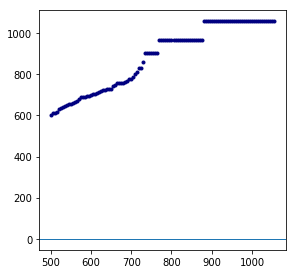

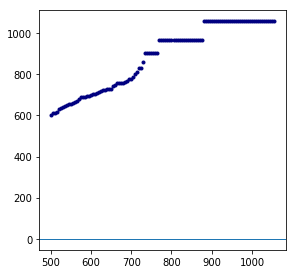

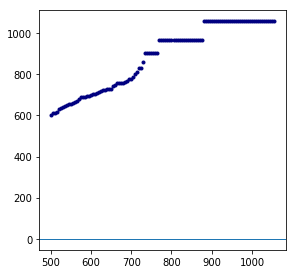

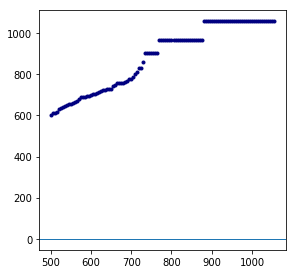

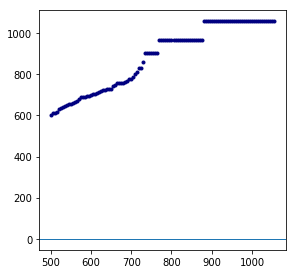

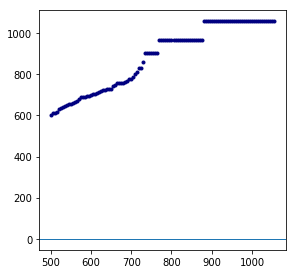

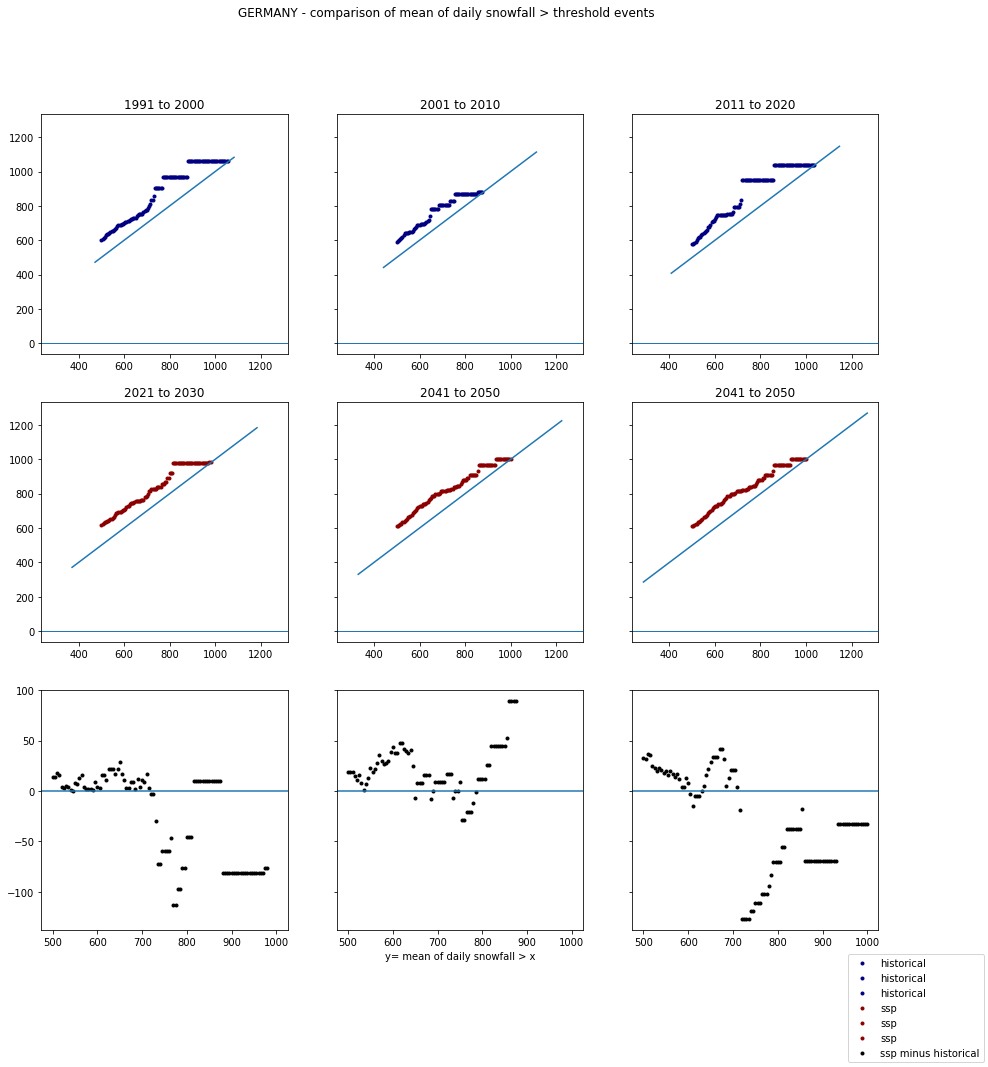

In [115]:
compare_decades_threshold_frequency(test,1991,2021,countryname='GERMANY',intensity=True,mean=True)
   

In [96]:
# routine to conduct multi-country-analysis:

countrylist = {}

countrylist['CANADA']=canada_box
countrylist['CHINA']=china_box
countrylist['FRANCE']=france_box
countrylist['GERMANY']=germany_box
countrylist['JAPAN']=japan_box
countrylist['NORWAY']=norway_box
countrylist['UNITED STATES']=contingentUS_box

print(countrylist)





{'CANADA': (-141.002148438, 41.6748535156, -52.6536621094, 83.1161132813), 'CHINA': (73.6073242187, 20.2637207031, 134.75234375, 53.5556152344), 'FRANCE': (-4.7625, 42.3404785156, 8.14033203125, 51.0971191406), 'GERMANY': (5.85751953125, 47.2788085938, 15.0166015625, 55.0587402344), 'JAPAN': (128.649121094, 30.24140625, 141.329199219, 45.4654785156), 'NORWAY': (4.7990234375, 58.0209472656, 30.9606445313, 71.1420898438), 'UNITED STATES': (-124.709960938, 24.5423339844, -66.9870117187, 49.3696777344)}


In [163]:
# define boxes for northern america and northern europe:

northern_america = (-140,30,-50,60)

northern_europe = (-25,42,44,68)

arealist = {}
arealist['NORTHERN AMERICA']=northern_america
#arealist['NORTHERN EUROPE']=northern_europe

results = {}

In [166]:
def multi_region_threshold_analysis(arealist,intensity=True):


    for i_key in tqdm(arealist.keys()):

        results ['preindustrial',i_key] = country_auto_decade_comparison_threshold(cubelist,8,arealist[i_key],1851,2021,i_key,intensity=True)

        

In [164]:
# set outputpath for analyis nc's

outputdir = '/p/tmp/quante/snow_simulation_data/notebook_output'
os.chdir(outputdir)


In [176]:
multi_region_threshold_analysis(arealist,intensity=True)




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [13:43<00:00, 823.38s/it]


In [178]:
print(results)

{('preindustrial', 'NORTHERN AMERICA'): {('historical', 1851, 1860): {'exceedance_array': array([[  500.,   505.,   510.,   515.,   520.,   525.,   530.,   535.,
          540.,   545.,   550.,   555.,   560.,   565.,   570.,   575.,
          580.,   585.,   590.,   595.,   600.,   605.,   610.,   615.,
          620.,   625.,   630.,   635.,   640.,   645.,   650.,   655.,
          660.,   665.,   670.,   675.,   680.,   685.,   690.,   695.,
          700.,   705.,   710.,   715.,   720.,   725.,   730.,   735.,
          740.,   745.,   750.,   755.,   760.,   765.,   770.,   775.,
          780.,   785.,   790.,   795.,   800.,   805.,   810.,   815.,
          820.,   825.,   830.,   835.,   840.,   845.,   850.,   855.,
          860.,   865.,   870.,   875.,   880.,   885.,   890.,   895.,
          900.,   905.,   910.,   915.,   920.,   925.,   930.,   935.,
          940.,   945.,   950.,   955.,   960.,   965.,   970.,   975.,
          980.,   985.,   990.,   995.,  1000.

In [179]:
import pickle
# use pickle to store intermiedate results
file = open('results_multidecade', 'wb')
pickle.dump(results,file)

In [122]:
def multi_region_threshold_plotting(arealist,intensity=False, mean=False):
        for i_key in tqdm(arealist.keys()):
            compare_decades_threshold_frequency(results ['preindustrial',i_key],1851,2021,countryname=i_key,intensity=intensity,mean=mean)
            compare_decades_threshold_frequency(results ['present',i_key],1991,2021,countryname=i_key,intensity=intensity,mean=mean)
            compare_decades_threshold_frequency(results ['later',i_key],1881,2051,countryname=i_key,intensity=intensity,mean=mean)
            compare_decades_threshold_frequency(results ['end_of_decade',i_key],1881,2071,countryname=i_key,intensity=intensity,mean=mean)

  0%|          | 0/1 [00:00<?, ?it/s]

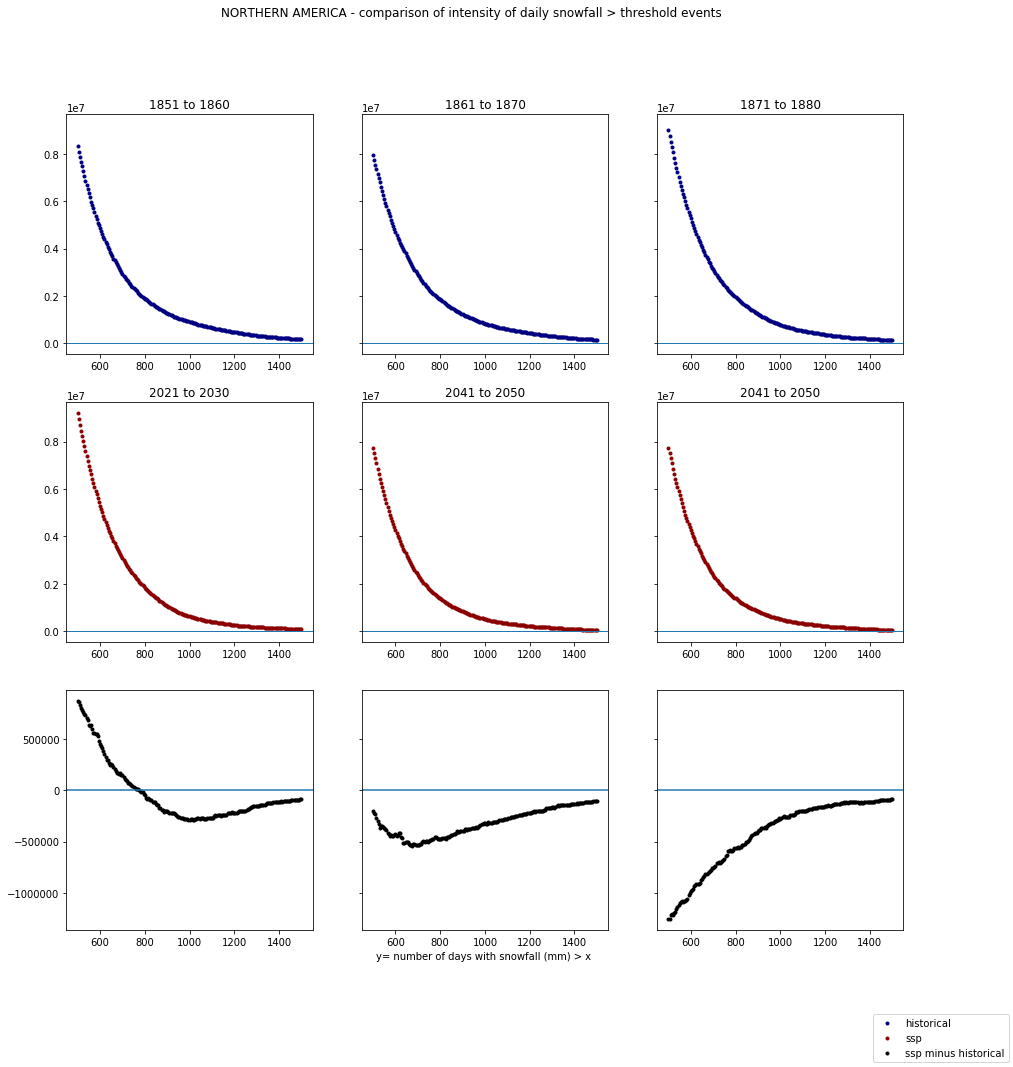

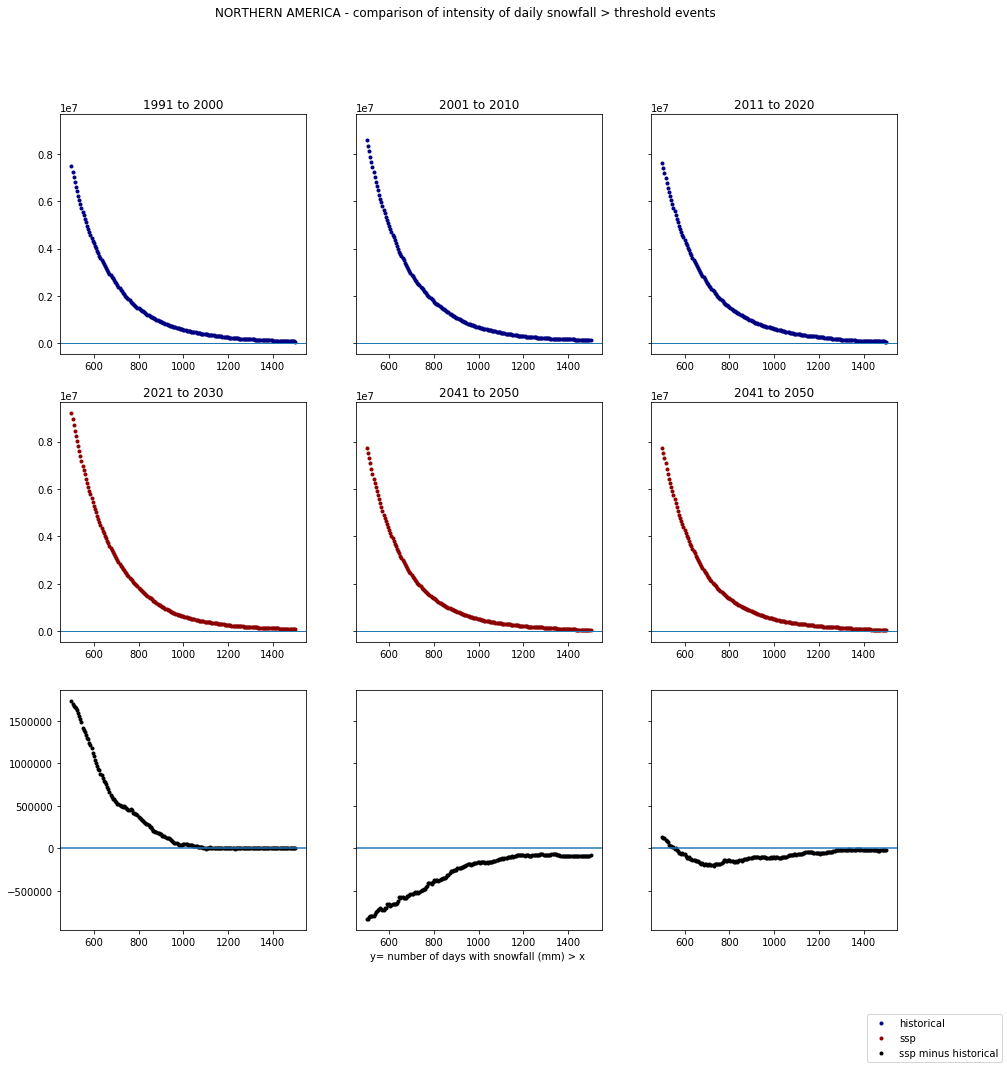

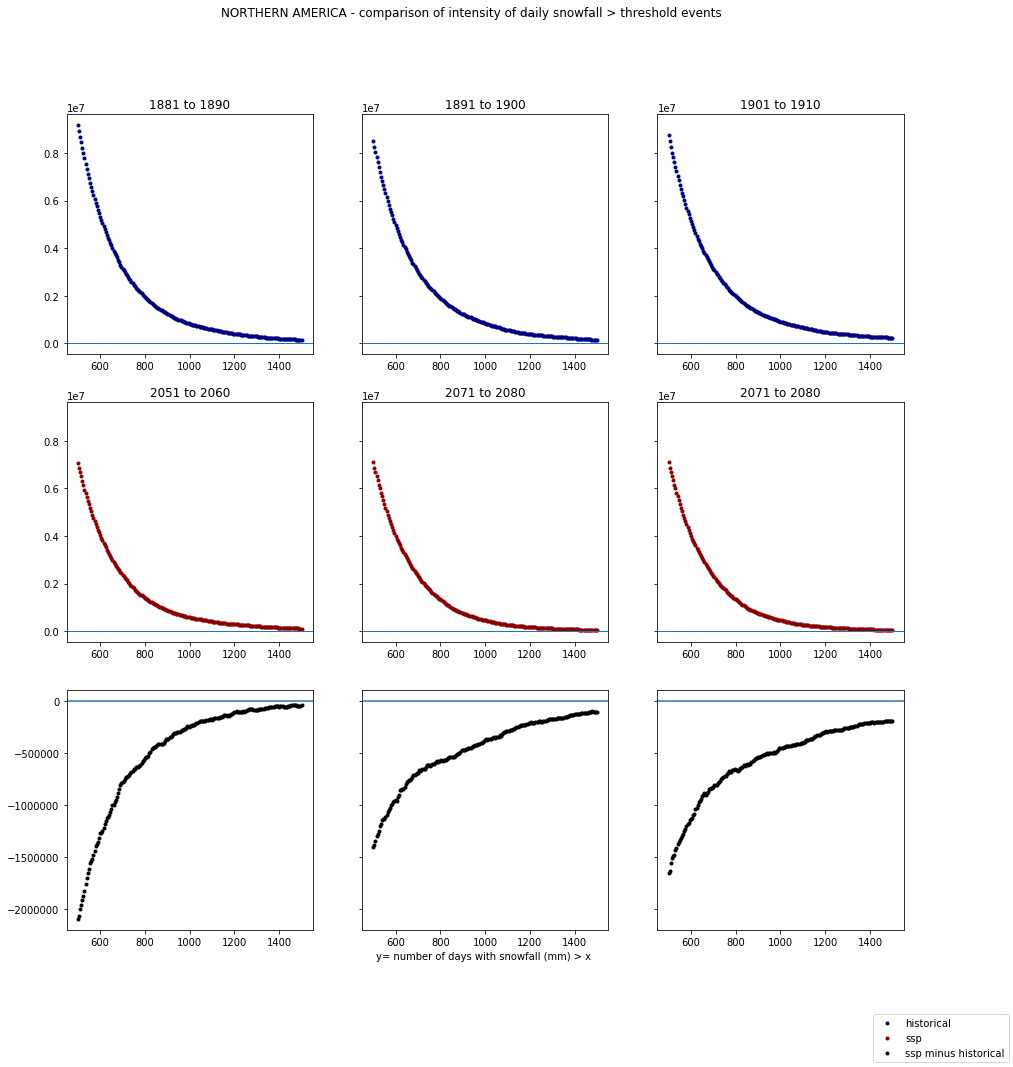

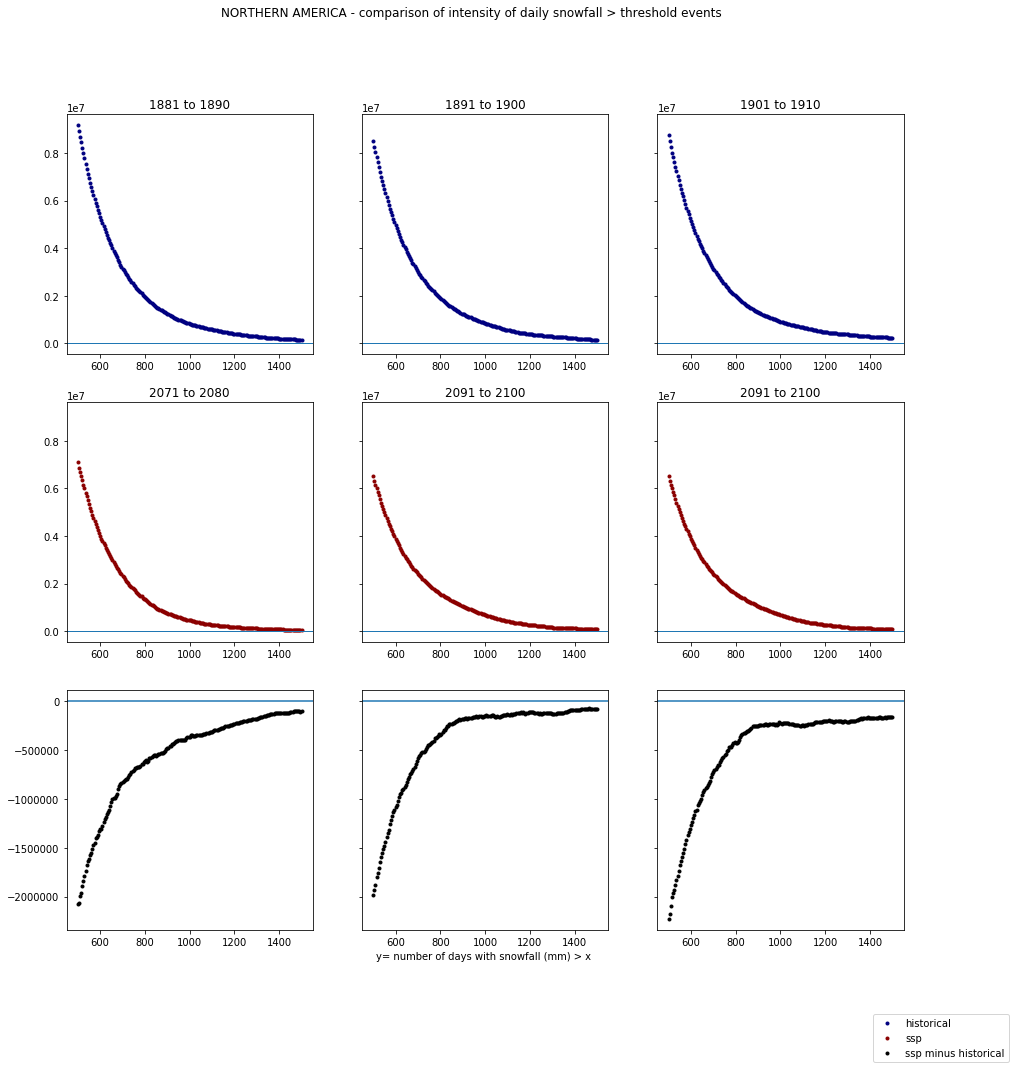

100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


In [145]:
multi_region_threshold_plotting(arealist,intensity=True,mean=False)

In [143]:
# plot map cubes:

def plot_cube(cube,startyear,finalyear,threshold):
        
        label = 'number of days with snowfall >'+str(threshold)+"mm"
        vmin=0
        vmax=25
        pcm = iris.plot.pcolormesh(cube, cmap=extremes_cmap,vmin=vmin,vmax=vmax)
        cbar = plt.colorbar(pcm, extend='both', orientation='horizontal',label=label)
        
        plt.title(str(startyear) + " to " + str(finalyear), fontsize=10)
        plt.gca().coastlines()
  
    
     

In [274]:
# define colormap whitefilling 0 values

colors_no_extreme = plt.cm.viridis(np.linspace(0, 0.05, 1))
colors_extreme = plt.cm.viridis(np.linspace(0.1, 1, 512))
all_colors = np.vstack((colors_no_extreme, colors_extreme))
# make color value for 0 white
all_colors[0] = (1, 1, 1, 1.0)

extremes_cmap = clr.LinearSegmentedColormap.from_list('extremes_map',
                                                                       all_colors)    


In [340]:
def plot_from_results_dict(results,key1,key2,threshold):
    plot_map_dict(results[key1][key2]['map_cubes'][(str(threshold),'map')],key2[1],key2[2],threshold)

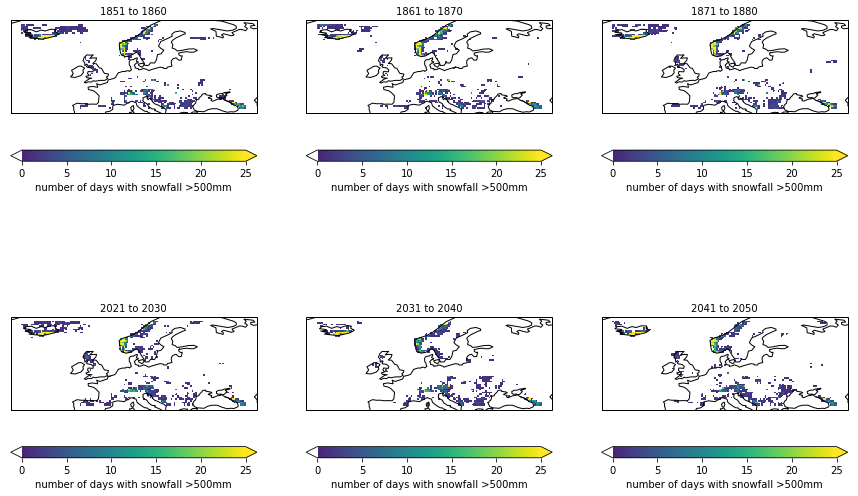

In [345]:
plot_results_dict(results,('preindustrial', 'NORTHERN EUROPE'),500)
plt.close()

In [344]:
def plot_complete_results_dict(results,threshold):
    keys = list(results.keys())
    for i_key in keys:
        plot_results_dict(results,i_key,threshold)

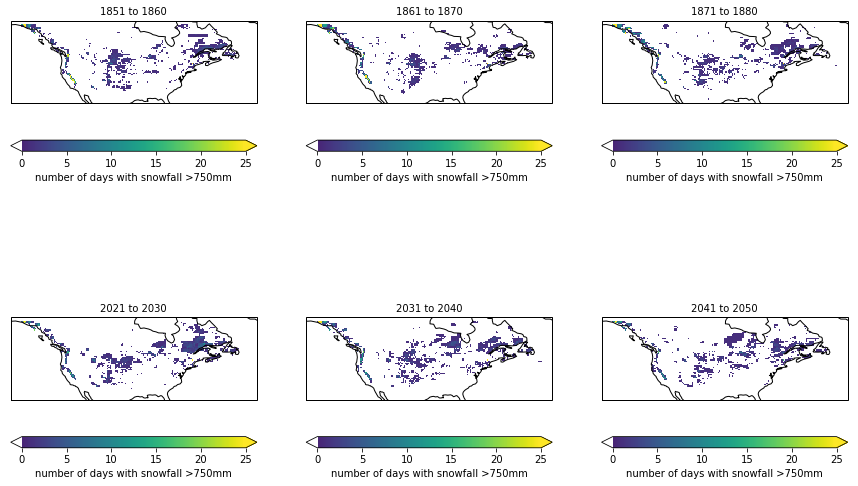

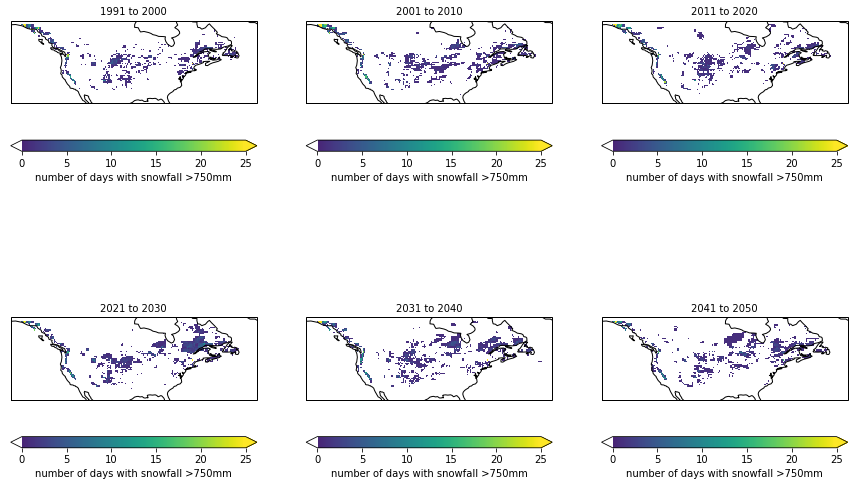

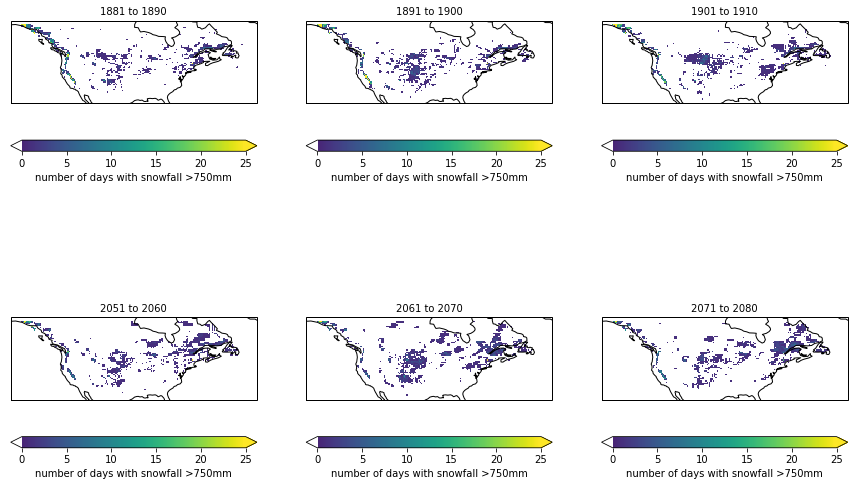

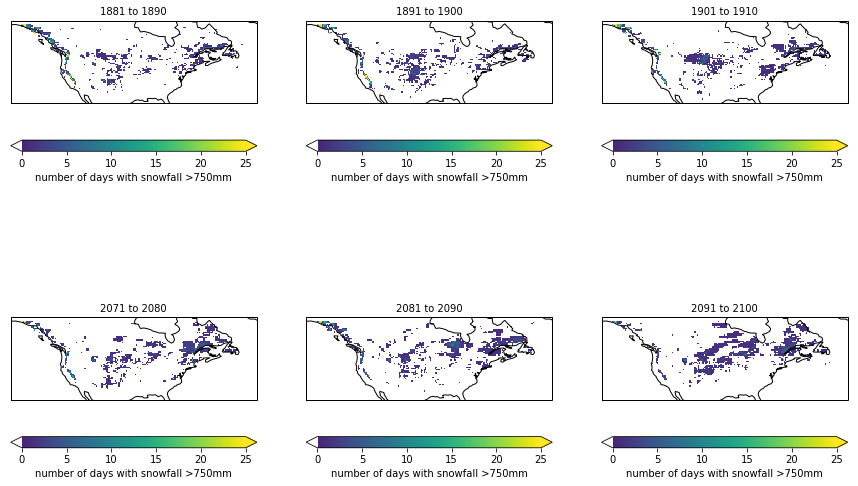

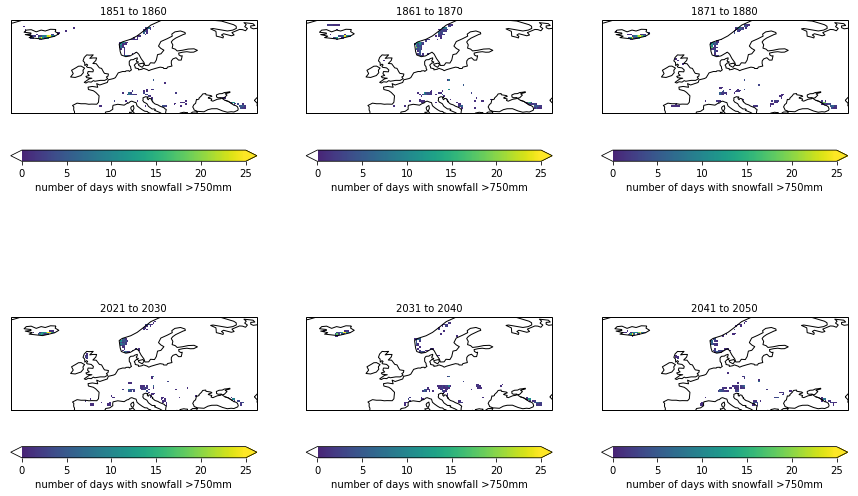

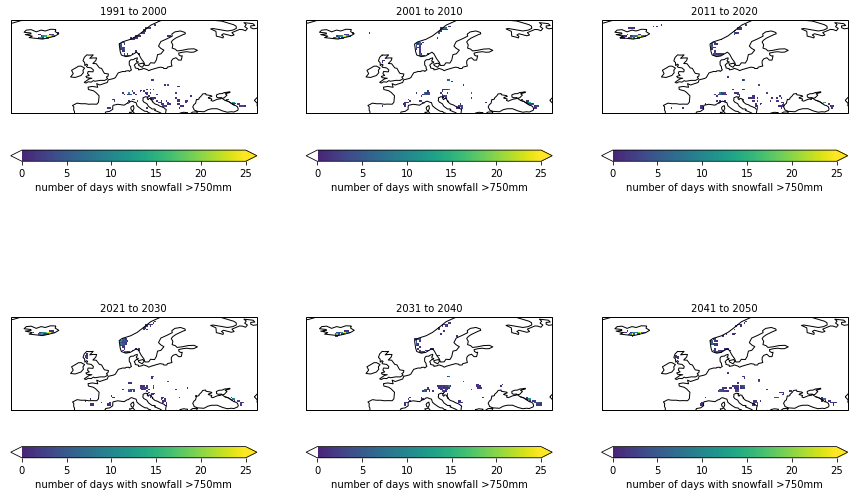

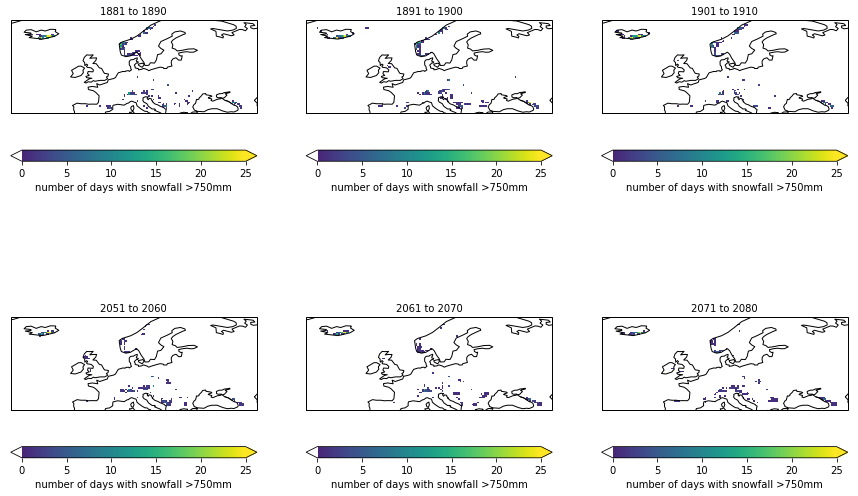

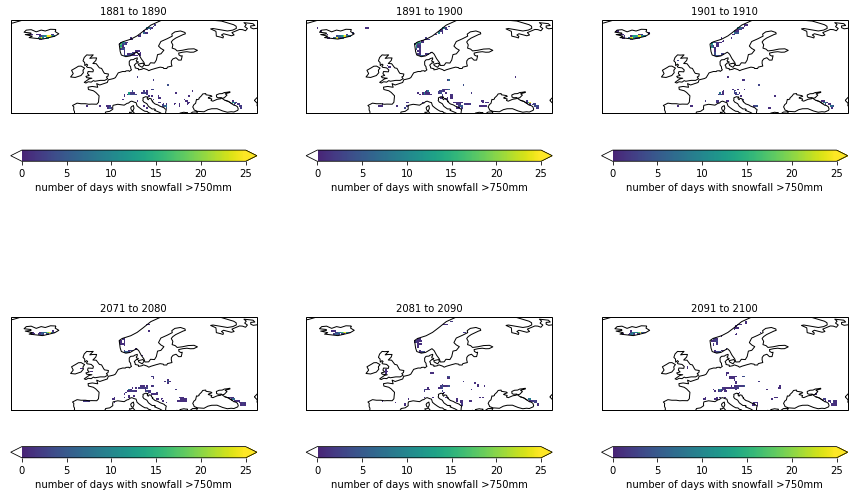

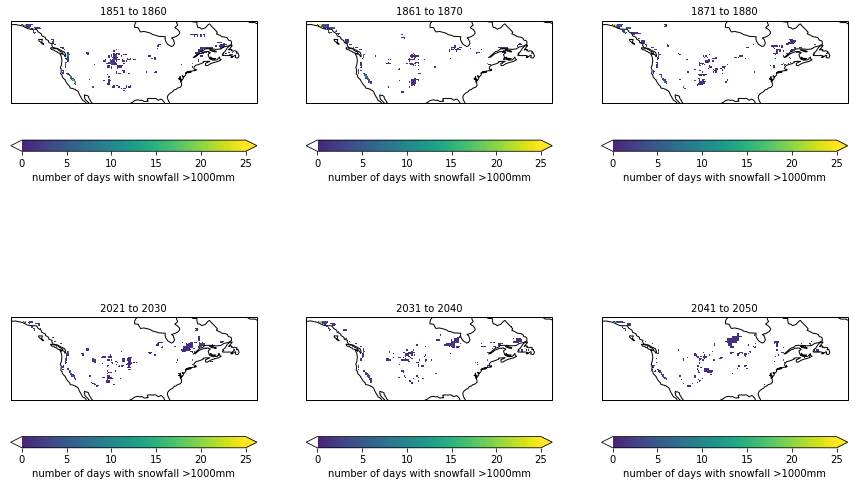

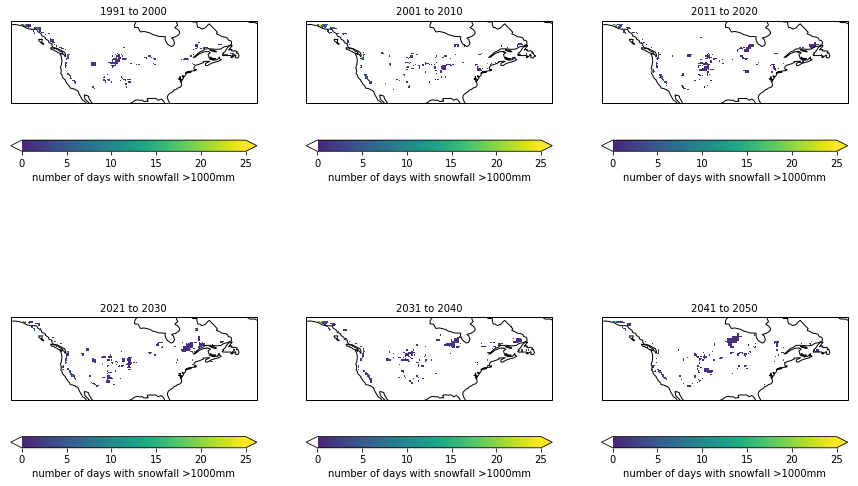

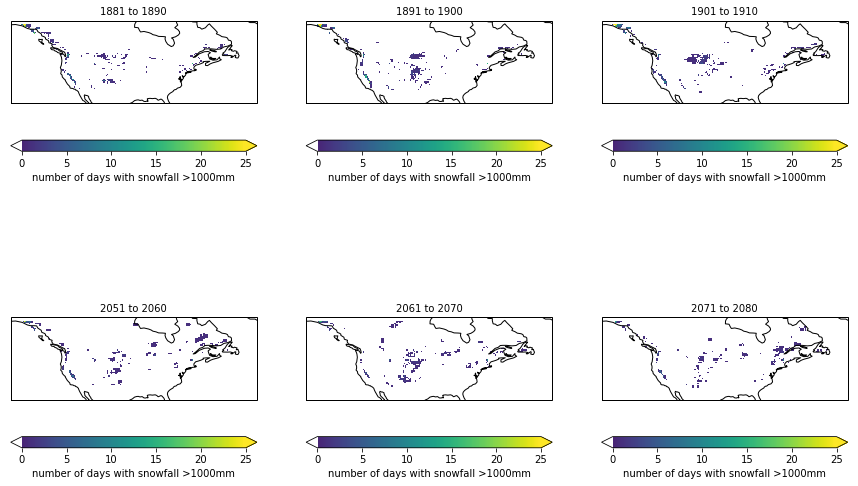

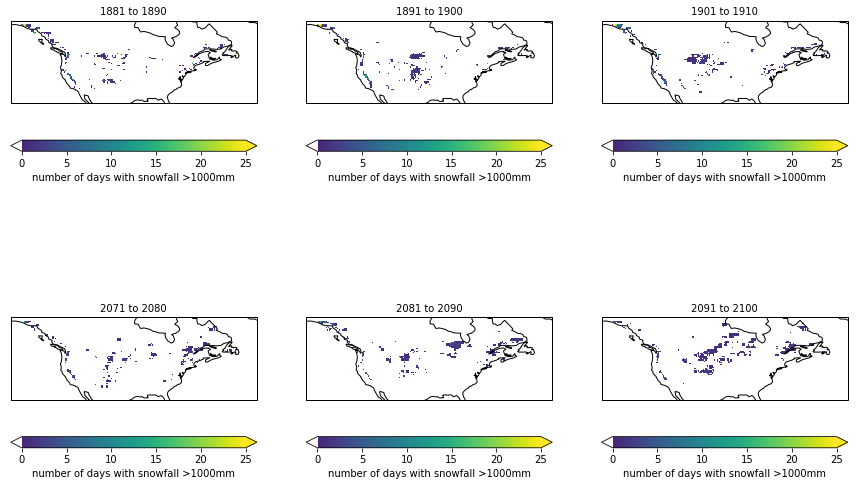

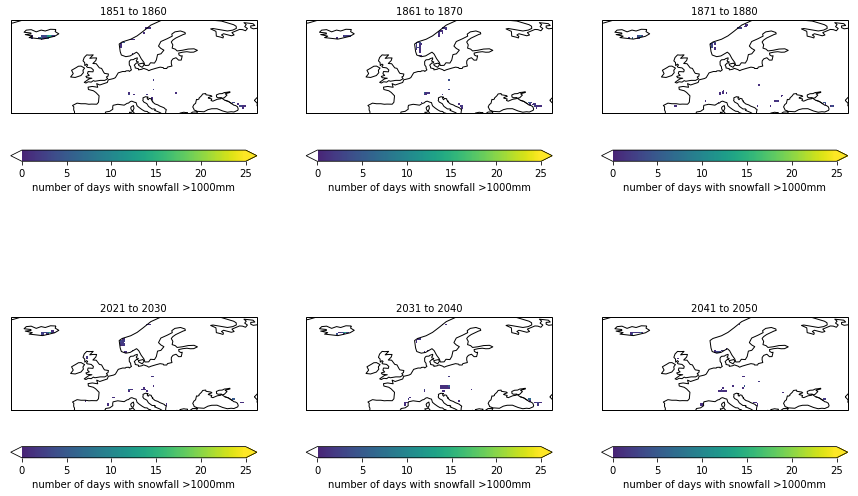

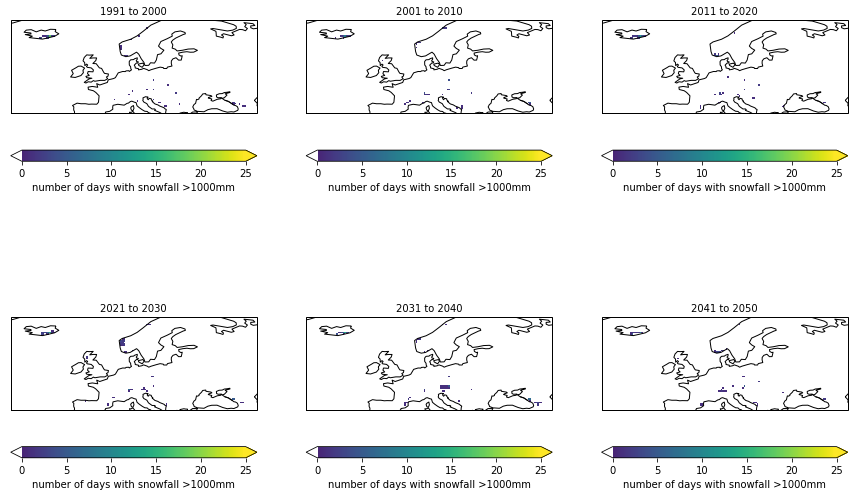

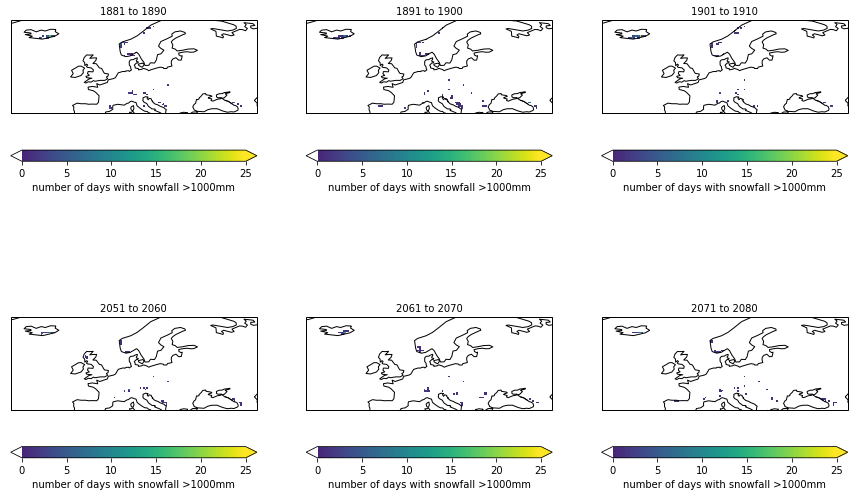

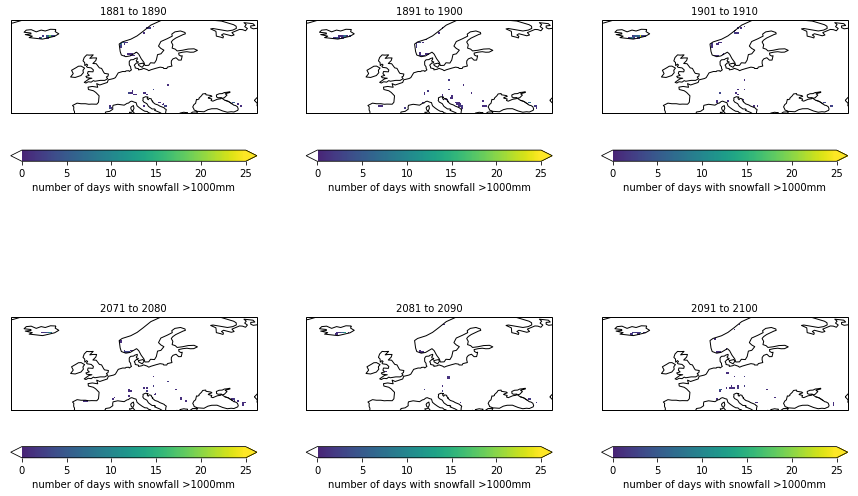

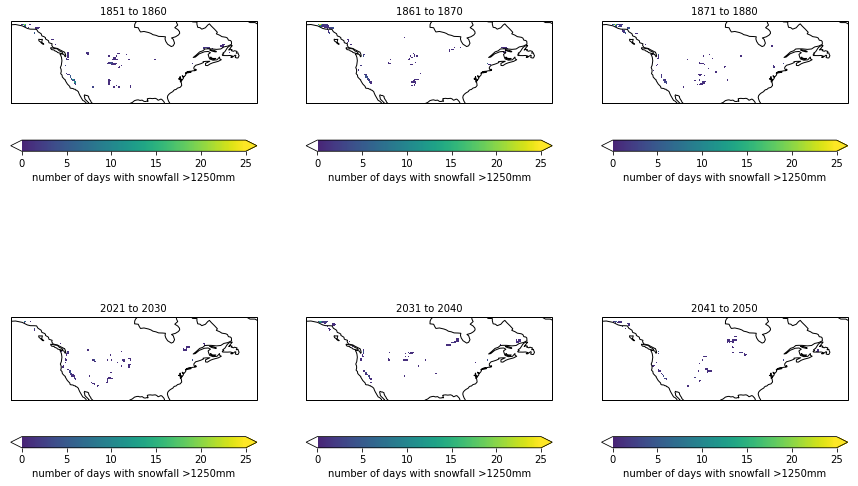

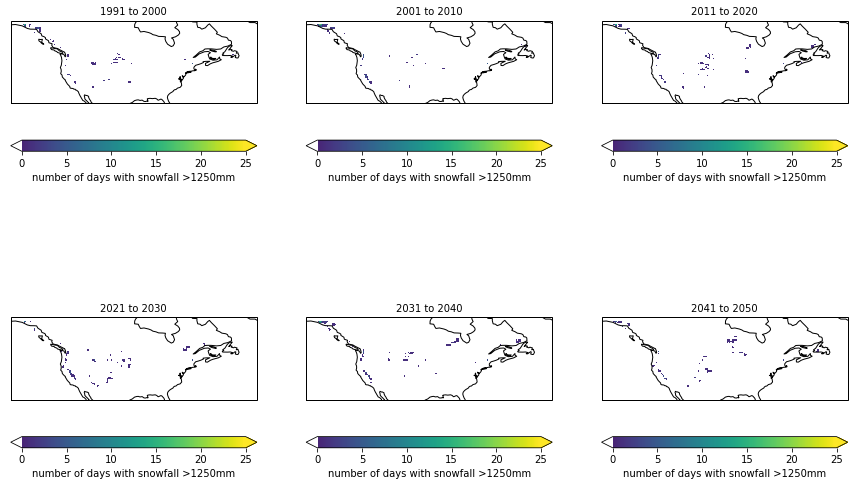

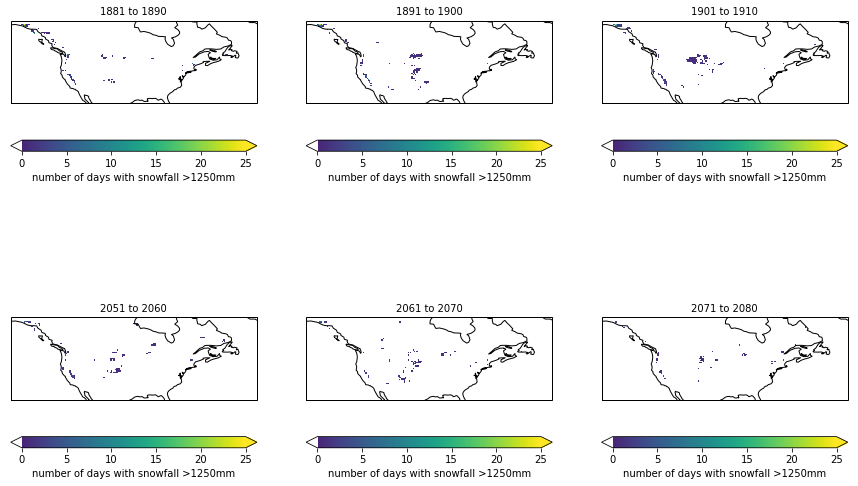

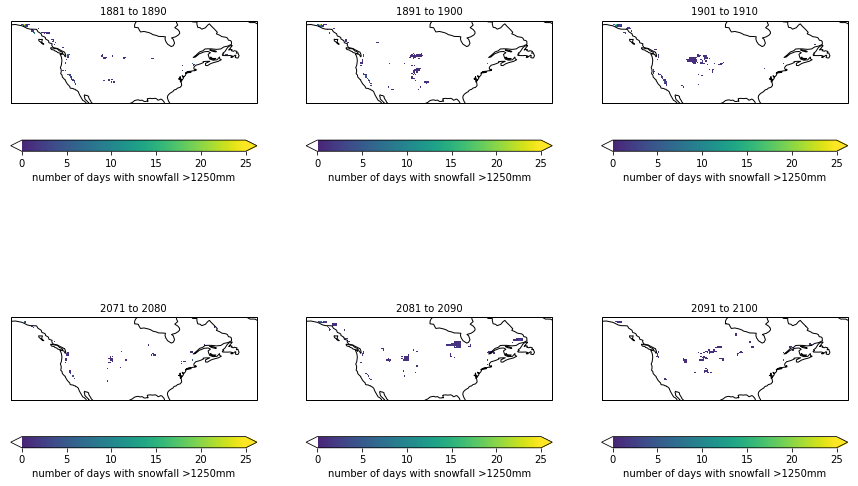

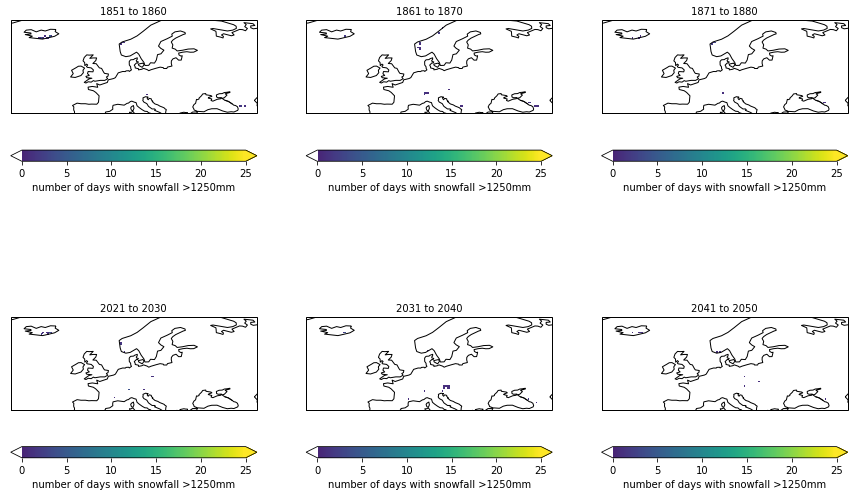

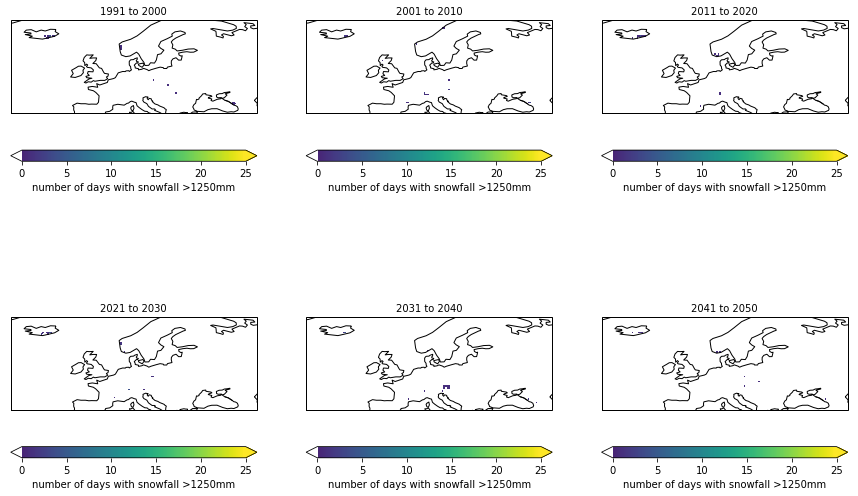

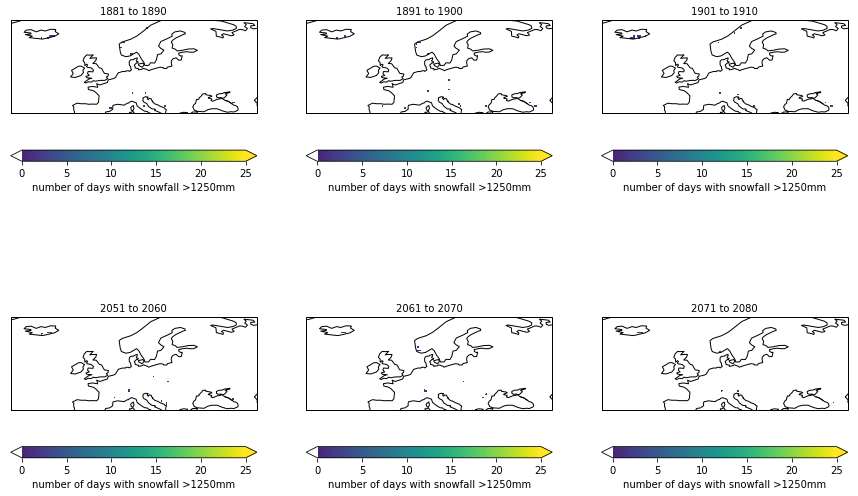

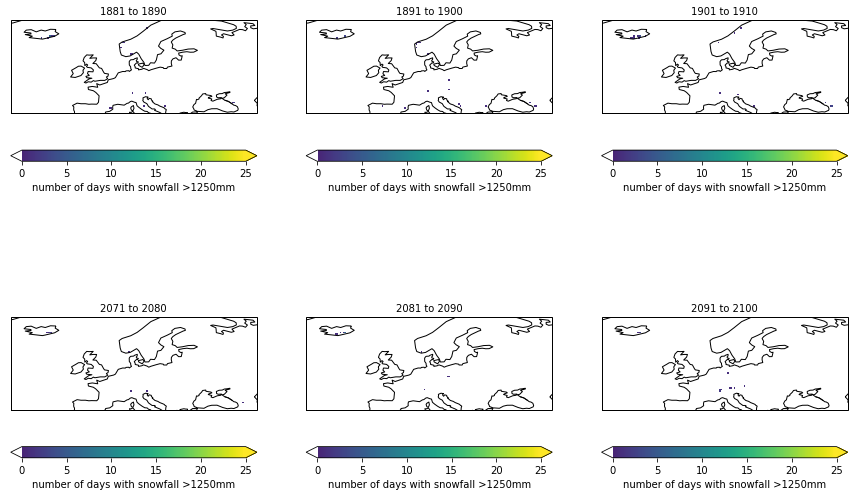

In [329]:
plot_complete_results_dict(results,750)
plot_complete_results_dict(results,1000)
plot_complete_results_dict(results,1250)

In [29]:
def plot_results_dict (results,key1,threshold):
    keys = list(results[key1].keys())
    fig = plt.figure(figsize=(15, 10)) 
    ax1 = plt.subplot(231)
    plot_from_results_dict(results,key1,keys[0],threshold)
    ax2 = plt.subplot(232)
    plot_from_results_dict(results,key1,keys[1],threshold)
    ax3 = plt.subplot(233)
    plot_from_results_dict(results,key1,keys[2],threshold)
    
    ax1 = plt.subplot(234)
    plot_from_results_dict(results,key1,keys[3],threshold)
    ax2 = plt.subplot(235)
    plot_from_results_dict(results,key1,keys[4],threshold)
    ax3 = plt.subplot(236)
    plot_from_results_dict(results,key1,keys[5],threshold)
    
    plt.show()
    filename = str(key1)+"_threshold_"+str(threshold)
    fig.savefig(filename+".png")
    plt.close()

In [30]:
def save_results(results,threshold):
    keys =list(results.keys())
    for i_key in keys:
        nd_keys = results[i_key].keys()
        for i_2key in nd_keys:
            filename = str(i_key)+str(i_2key)+"_"+str(threshold)
            iris.save(results[i_key][i_2key]['map_cubes'][(str(threshold),'map')],filename+'.nc')

In [31]:
# test of difference calculation:

diff_test = results[('preindustrial', 'NORTHERN EUROPE')]['historical', 1851, 1860]['map_cubes'][('500','map')]

print(map_test)

diff_test_2 = results[('present', 'NORTHERN EUROPE')]['historical', 2011, 2020]['map_cubes'][('500','map')]

plot_difference_cube(diff_test_2-diff_test,'historical',2011,2020,'hist',1851,1860,500)
plt.show()
plt.close()


NameError: name 'map_test' is not defined

In [42]:
# plot map cubes:

import matplotlib.colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_difference_cube(cube,scenario_data,startyear_data,finalyear_data,scenario_comparison,startyear_comparison,finalyear_comparison,threshold):
        
        label = 'difference of number of days with snowfall >'+str(threshold)+"mm"
        vmin=-15
        vmax=15
        colormap = plt.get_cmap('RdBu',30)
        
        pcm = iris.plot.pcolormesh(cube, cmap=colormap,vmin=vmin,vmax=vmax)
        
        cbar = plt.colorbar(pcm, extend='both', orientation='horizontal',label=label)
        cbar.minorticks_on()
        plt.title(scenario_data+ ": "+str(startyear_data) + " to " + str(finalyear_data) +"\n -"+
                  scenario_comparison+ ": "+str(startyear_comparison) + " to " + str(finalyear_comparison), fontsize=10)
        plt.gca().coastlines('50m')
        plt.gca().add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_1_states_provinces_lines','10m',
        edgecolor='gray', facecolor='none'))
        

In [33]:
def plot_difference_dict (datadict):
    plot_difference_cube(datadict['cube'],datadict['scenario'],datadict['startyear'],datadict['finalyear_datadict'],
                         datadict['scenario_subtrahend'],datadict['startyear_subtrahend'],datadict['finalyear_subtrahend'],datadict['threshold'])

In [34]:
def plot_differences (data1,data2,data3,data4,data5,data6,filename,title):
    fig = plt.figure(figsize=(20, 8)) 
    ax1 = plt.subplot(231)
    plot_difference_dict (data1)
    ax2 = plt.subplot(232)
    plot_difference_dict(data2)
    ax3 = plt.subplot(233)
    plot_difference_dict(data3)
    ax4 = plt.subplot(234)
    plot_difference_dict(data4)
    ax5 = plt.subplot(235)
    plot_difference_dict(data5)
    ax6 = plt.subplot(236)
    plot_difference_dict(data6)
    fig.suptitle(title)
    plt.show()
    fig.savefig(filename+".png")
    plt.close()

In [35]:
def difference_dict(data_key1,data_key2,threshold,
                   subtrahend_key1,subtrahend_key2):
    data = results[data_key1][data_key2]['map_cubes'][(str(threshold),'map')]
    subtrahend = results[subtrahend_key1][subtrahend_key2]['map_cubes'][(str(threshold),'map')]
    diffdict = {}
    diffdict ['cube'] = data-subtrahend
    diffdict['scenario'] =data_key2[0]
    diffdict['startyear']=data_key2[1]
    diffdict['finalyear_datadict']=data_key2[2]
    diffdict['scenario_subtrahend']=subtrahend_key2[0]
    diffdict['startyear_subtrahend']=subtrahend_key2[1]
    diffdict['finalyear_subtrahend']=subtrahend_key2[2]
    diffdict['threshold']=threshold
    return diffdict

In [36]:
# calculate preindustrial mean

data_1851_1860 = results[('preindustrial', 'NORTHERN AMERICA')]['historical', 1851, 1860]['map_cubes'][('500','map')]
data_1861_1870 = results[('preindustrial', 'NORTHERN AMERICA')]['historical', 1861, 1870]['map_cubes'][('500','map')]
data_1871_1880 = results[('preindustrial', 'NORTHERN AMERICA')]['historical', 1871, 1880]['map_cubes'][('500','map')]

preindustrial_mean = (data_1851_1860+data_1861_1870+data_1871_1880)/3
dict_map = {}
dict_map [('500','map')]  = preindustrial_mean
dict_cubes = {}
dict_cubes ['map_cubes'] = dict_map
dict_scenario = results[('preindustrial', 'NORTHERN AMERICA')]
dict_scenario ['historical_decadal_mean', 1851, 1880] = dict_cubes
results[('preindustrial', 'NORTHERN AMERICA')] = dict_scenario


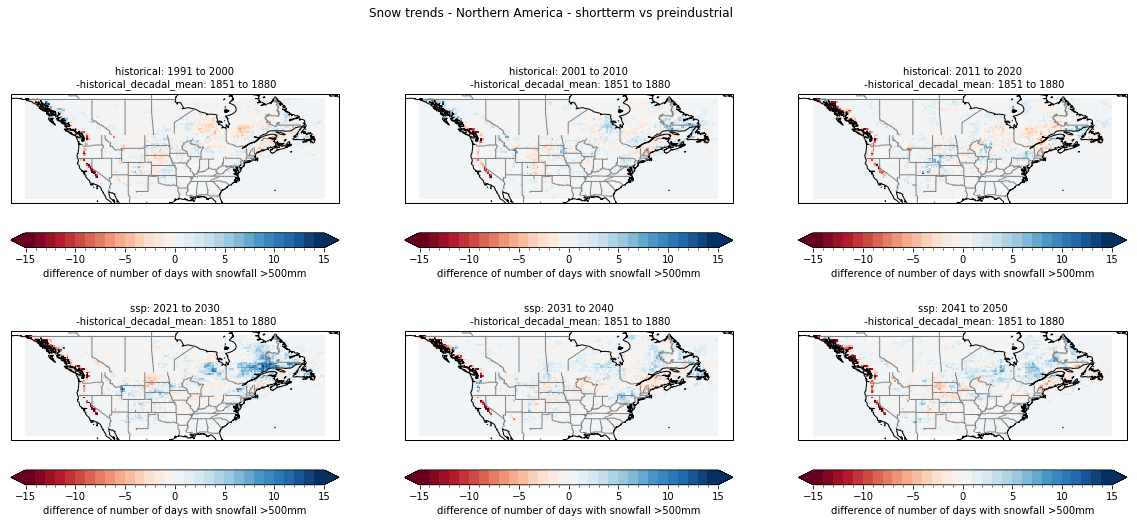

In [43]:
# calculate differences to preindustrial mean

key1= ('present', 'NORTHERN AMERICA')
key2 = ('historical', 1991, 2000)
threshold = 500
key1_subtrahend = ('preindustrial', 'NORTHERN AMERICA')
key2_subtrahend = ('historical_decadal_mean', 1851, 1880)

diff1 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


key2 = ('historical', 2001, 2010)

diff2 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


key2 = ('historical', 2011, 2020)

diff3 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)

key1= ('present', 'NORTHERN AMERICA')
key2 = ('ssp', 2021, 2030)

diff4 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


key2 = ('ssp', 2031, 2040)

diff5 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)

key2 = ('ssp', 2041, 2050)

diff6 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


plot_differences(diff1,diff2,diff3,diff4,diff5,diff6,'present_minus_preindustrial_mean','Snow trends - Northern America - shortterm vs preindustrial')

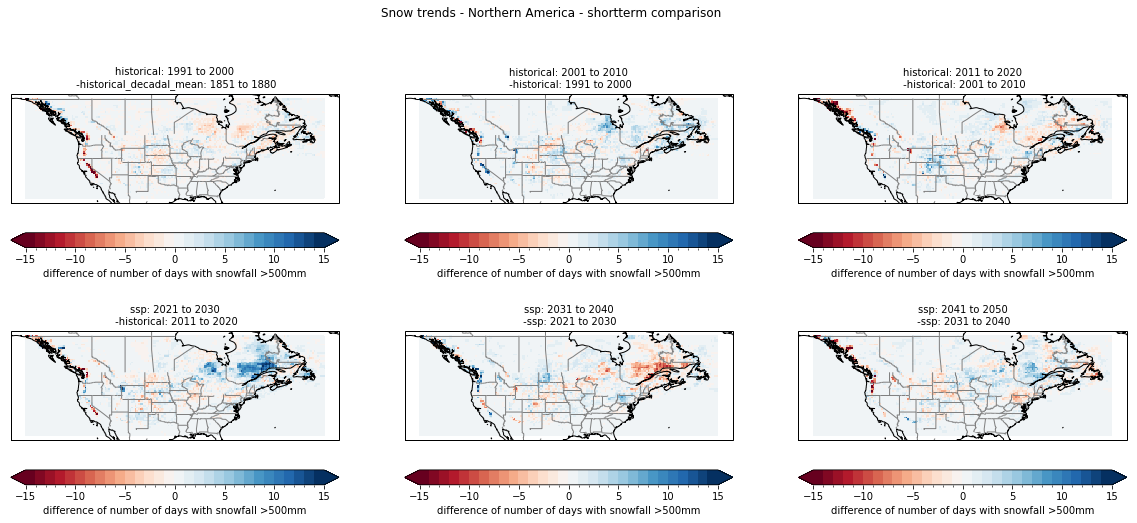

In [44]:
# calculate differences to previous decad mean

key1= ('present', 'NORTHERN AMERICA')
key2 = ('historical', 1991, 2000)
threshold = 500
key1_subtrahend = ('preindustrial', 'NORTHERN AMERICA')
key2_subtrahend = ('historical_decadal_mean', 1851, 1880)

diff1 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)



key1_subtrahend = key1
key2_subtrahend = key2
key2 = ('historical', 2001, 2010)
diff2 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


key2_subtrahend = key2
key2 = ('historical', 2011, 2020)

diff3 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


key2_subtrahend = key2
key2 = ('ssp', 2021, 2030)

diff4 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)

key2_subtrahend = key2
key2 = ('ssp', 2031, 2040)

diff5 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)

key2_subtrahend = key2
key2 = ('ssp', 2041, 2050)

diff6 = difference_dict(key1,key2,threshold,key1_subtrahend,key2_subtrahend)


plot_differences(diff1,diff2,diff3,diff4,diff5,diff6,'present_minus_prev_decade','Snow trends - Northern America - shortterm comparison')

In [413]:
print (results[('preindustrial', 'NORTHERN AMERICA')])

{('historical', 1851, 1860): {'exceedance_array': array([[  500.,   505.,   510.,   515.,   520.,   525.,   530.,   535.,
          540.,   545.,   550.,   555.,   560.,   565.,   570.,   575.,
          580.,   585.,   590.,   595.,   600.,   605.,   610.,   615.,
          620.,   625.,   630.,   635.,   640.,   645.,   650.,   655.,
          660.,   665.,   670.,   675.,   680.,   685.,   690.,   695.,
          700.,   705.,   710.,   715.,   720.,   725.,   730.,   735.,
          740.,   745.,   750.,   755.,   760.,   765.,   770.,   775.,
          780.,   785.,   790.,   795.,   800.,   805.,   810.,   815.,
          820.,   825.,   830.,   835.,   840.,   845.,   850.,   855.,
          860.,   865.,   870.,   875.,   880.,   885.,   890.,   895.,
          900.,   905.,   910.,   915.,   920.,   925.,   930.,   935.,
          940.,   945.,   950.,   955.,   960.,   965.,   970.,   975.,
          980.,   985.,   990.,   995.,  1000.,  1005.,  1010.,  1015.,
         1020.

In [ ]:
# generate difference dicts:
key1= ('present', 'NORTHERN AMERICA')
key2 = ('historical', 1991, 2000)
key1_subtrahend = ('preindustrial', 'NORTHERN AMERICA')

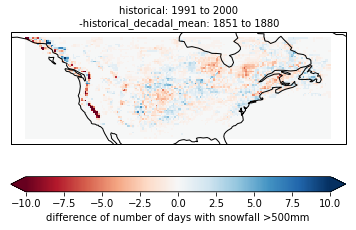

In [397]:
plot_difference_dict(test)
plt.show()

In [387]:
# define function for multi-country density analysis

def multi_country_density_plotting_early (countrylist,population_boolean):


    for i_key in tqdm(countrylist.keys()):

        country_early_decade_comparison(cubelist,countrylist[i_key],'djf',i_key,population_boolean)


In [388]:
# define function for multi-country density analysis

def multi_country_density_plotting_late (countrylist,population_boolean):


    for i_key in tqdm(countrylist.keys()):

        country_decade_comparison(cubelist,countrylist[i_key],'djf',i_key,population_boolean)


### Population weighted data analysis

In [ ]:
multi_country_density_plotting_early(countrylist,True)

In [ ]:
multi_country_density_plotting_late(countrylist,True)

### Unweighted data analysis

In [ ]:
multi_country_density_plotting_early(countrylist,False)

In [ ]:
multi_country_density_plotting_late(countrylist,False)

### Multi-day analysis methods

In [ ]:
#### count exceedance of given threshhold (e.g. historical quantiles)

# definie threshold cube
data_cube  = country_filter(cubelist,germany_box)['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
ssp126_cube  = country_filter(cubelist,germany_box)['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
ssp585_cube  = country_filter(cubelist,germany_box)['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
threshold_percentile = 95
threshold_cube = data_cube.collapsed('time',iris.analysis.PERCENTILE,percent=threshold_percentile)





In [ ]:


event_length = 3 # number of days


def count_exceedances (data_cube,threshold_cube,event_length):
    exceedance_data = (data_cube.data - threshold_cube.data)
    extended_varname = data_cube.var_name + "_threshold_exceedance" + str(event_length)
    exceedance_cube = iris.cube.Cube(exceedance_data)
    exceedance_cube.var_name = extended_varname
    return exceedance_cube.rolling_window("time",iris.analysis.COUNT,event_length,function = lambda x: x>0)

exceedance_historical = count_exceedances(data_cube,threshold_cube,3)
exceedance_ssp126 = count_exceedances(ssp126_cube,threshold_cube,3)
exceedance_ssp585 = count_exceedances(ssp585_cube,threshold_cube,3)


print(exceedance_historical.dim_coords)

In [ ]:
compare_timespans (exceedance_historical,exceedance_ssp126,exceedance_ssp585,50,30, 1851,1911,2021,2071,cumulative=False,countryname="",zoom=False,population=False)
    

### Quantile analysis with maps:

In [ ]:
# generate data identifier from keys

def identify_data (key):
    data_identifier = {}
    data_identifier['model'] = (key [0])
    data_identifier['scenario'] = (key [1])
    return data_identifier

In [ ]:
# define PickleResultsquantile analysis method
quantiles = [90,95,99,99.9,99.99]

def quantile_analysis(cube,quantiles,data_identifier):
    quantile_data = cube.collapsed('time', iris.analysis.PERCENTILE, percent=quantiles)
    iris.save(quantile_data, data_identifier + "_quantile_analysis.nc")


In [ ]:
# quantiles for specified timeframe

startyear = 2021
finalyear = 2050

def scenario_quantiles (cubelist,historical_startyear,ssp_startyear,timespan,quantiles,population=False):
    for i_key in tqdm(cubelist.keys()):
        cube = unify_concatenate(cubelist [i_key])
        
        # identify data
        identifier_dict = identify_data(i_key)
        
        if (identifier_dict['scenario']=='historical'):
            startyear = historical_startyear
        else:
            startyear = ssp_startyear
        
        finalyear = startyear+timespan-1
    
        data_identifier = str(identifier_dict['model'])+"_"+str(identifier_dict['scenario'])+"_"+str(startyear)+"-"+str(finalyear)
        # extract years
        limited_cube = extract_dates(cube,startyear,finalyear)
        if (population):
            limited_cube = population_scaling(limited_cube,population_2020)
            data_identifier += "_multiplied_with_population"
        quantile_analysis(limited_cube,quantiles,data_identifier)

In [ ]:
scenario_quantiles (cubelist,1851,2021,30,quantiles)
scenario_quantiles (cubelist,1881,2071,30,quantiles)

In [ ]:
scenario_quantiles (cubelist,1851,2021,30,quantiles,population=True)
scenario_quantiles (cubelist,1881,2071,30,quantiles,population=True)